# RNNによる画像生成
画像を時系列のデータと捉えることで、RNNにより画像を生成することが可能になります。  
今回は、画像データを使ってRNNを訓練し、画像の上半分をもとに画像の下半分を生成します。  
RNNの層にはLSTMを使用します。  


## Fashion-MNIST
torchvision.datasetsを使い、Fashion-MNISTを読み込みます。  
Fashion-MNISTは、6万枚のファッションアイテム画像にラベルをつけたたデータセットです。  
以下のコードでは、Fashion-MNISTを読み込み、ランダムな25枚の画像を表示します。

データの数: 60000


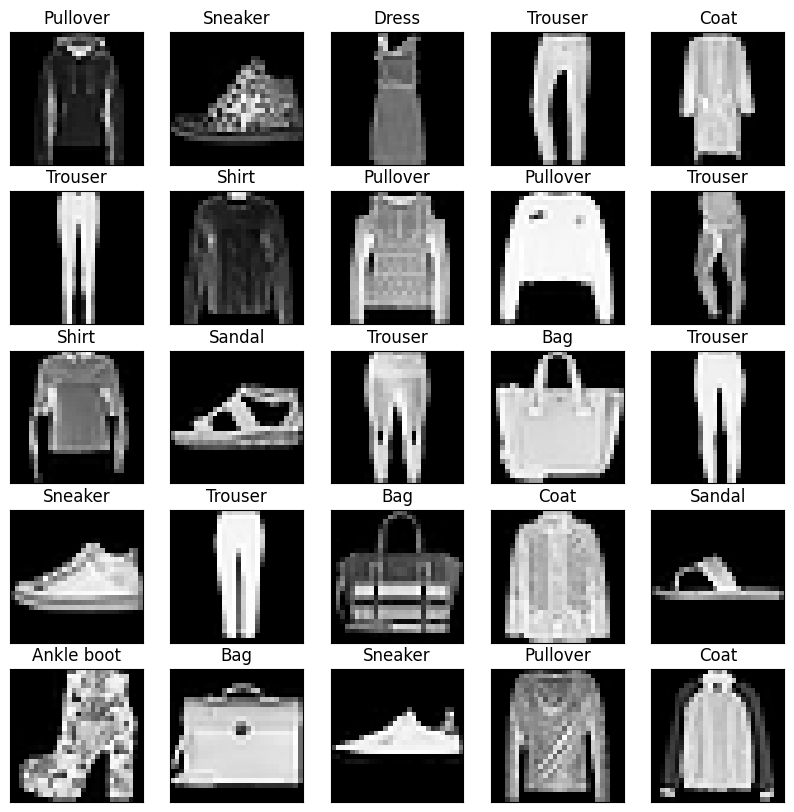

In [3]:
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

fmnist_data = FashionMNIST(root="./data",
                            train=True,download=True,
                            transform=transforms.ToTensor())
fmnist_classes = np.array(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                            "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"])
print("データの数:", len(fmnist_data))

n_image = 25  # 表示する画像の数
fmnist_loader = DataLoader(fmnist_data, batch_size=n_image, shuffle=True)
dataiter = iter(fmnist_loader)  # イテレータ
images, labels = dataiter.__next__()  # 最初のバッチを取り出す

img_size = 28
plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    plt.subplot(5,5,i+1)
    plt.imshow(images[i].reshape(img_size, img_size), cmap="Greys_r")
    label = fmnist_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

## データの前処理
画像データをRNNに適した形に整えます。  
画像を時系列データに変換しますが、正解は時系列の次の行にします。

In [5]:
import torch
from torch.utils.data import DataLoader

n_time = 14  # 時系列の数
n_in = img_size  # 入力層のニューロン数
n_mid = 256  # 中間層のニューロン数
n_out = img_size  # 出力層のニューロン数
n_sample_in_img = img_size-n_time  # 1枚の画像中のサンプル数

dataloader = DataLoader(fmnist_data, batch_size=len(fmnist_data), shuffle=False)
dataiter = iter(dataloader)  # イテレータ
train_imgs, labels = dataiter.__next__()  # データを取り出す
train_imgs = train_imgs.reshape(-1, img_size, img_size)

n_sample = len(train_imgs) * n_sample_in_img  # サンプル数

input_data = np.zeros((n_sample, n_time, n_in))  # 入力
correct_data = np.zeros((n_sample, n_out))  # 正解
for i in range(len(train_imgs)):
    for j in range(n_sample_in_img):
        sample_id = i*n_sample_in_img + j
        input_data[sample_id] = train_imgs[i, j:j+n_time]
        correct_data[sample_id] = train_imgs[i, j+n_time]

input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成

train_loader = DataLoader(dataset, batch_size=128, shuffle=True)  # DataLoaderの設定

## テスト用のデータ
今回は、訓練済みのモデルが機能することを確かめるために使用します。

In [7]:
n_disp = 10  # 生成し表示する画像の数

disp_data = FashionMNIST(root="./data",
                            train=False,download=True,
                            transform=transforms.ToTensor())
disp_loader = DataLoader(disp_data, batch_size=n_disp, shuffle=False)
dataiter = iter(disp_loader)  # イテレータ
disp_imgs, labels = dataiter.__next__()  # データを取り出す
disp_imgs = disp_imgs.reshape(-1, img_size, img_size)

## 画像生成用の関数
以下の関数は、オリジナルの画像`disp_imgs`と、この画像の上半分をもとに下半分を生成した`gen_imgs`を並べて表示します。  
最初は画像の上半分をシードにして新たな行を生成しますが、次はその新たな行を含む直近の時系列からさらに次の行を生成します。  
これを繰り返すことで、下半分の画像が生成されます。  

In [9]:
def generate_images():
    # オリジナルの画像
    print("Original:")
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
        ax = plt.subplot(1, n_disp, i+1)
        plt.imshow(disp_imgs[i], cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)  # 軸を非表示に
        ax.get_yaxis().set_visible(False)
    plt.show()

    # 下半分をRNNにより生成した画像
    print("Generated:")
    gen_imgs = disp_imgs.clone()
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
        for j in range(n_sample_in_img):
            x = gen_imgs[i, j:j+n_time].reshape(1, n_time, img_size)
            x = x.cuda()  # GPU対応
            gen_imgs[i, j+n_time] = net(x)[0]
        ax = plt.subplot(1, n_disp, i+1)
        plt.imshow(gen_imgs[i].detach(), cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)  # 軸を非表示に
        ax.get_yaxis().set_visible(False)
    plt.show()

## モデルの構築
`nn.Module`モジュールを継承したクラスとして、モデルを構築します。  
LSTMは`nn.LSTM`を使って実装することができます。

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.LSTM(  # LSTM層
            input_size=n_in,  # 入力サイズ
            hidden_size=n_mid,  # ニューロン数
            batch_first=True,  # 入力を (バッチサイズ, 時系列の数, 入力の数) にする
        )
        self.fc = nn.Linear(n_mid, n_out)  # 全結合層

    def forward(self, x):
        y_rnn, (h, c) = self.rnn(x, None)  # hは次の時刻に渡される値、 cは記憶セル
        y = self.fc(y_rnn[:, -1, :])  # yは最後の時刻の出力
        return y

net = Net()
net.cuda()  # GPU対応
print(net)

Net(
  (rnn): LSTM(28, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=28, bias=True)
)


## 学習
モデルを訓練します。  
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行います。  
学習中、一定のエポック間隔ごとに誤差の表示と画像の生成が行われます。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。

Epoch: 0 Loss_Train: 0.017501291631318375
Original:


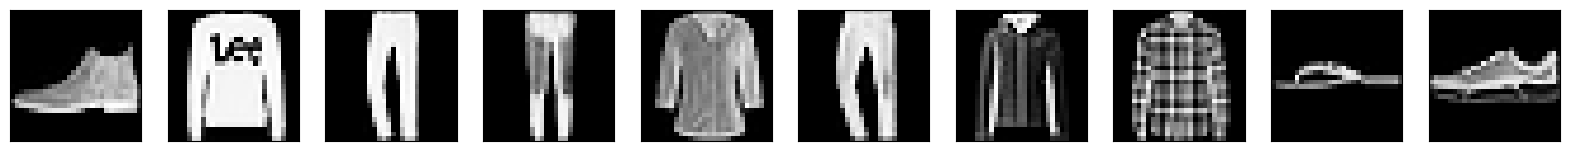

Generated:


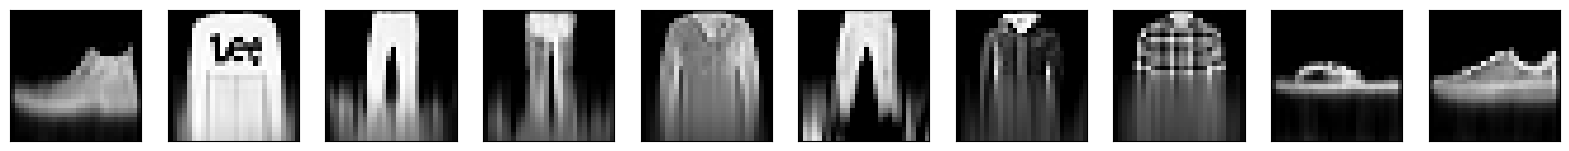

Epoch: 1 Loss_Train: 0.013600805062180804
Original:


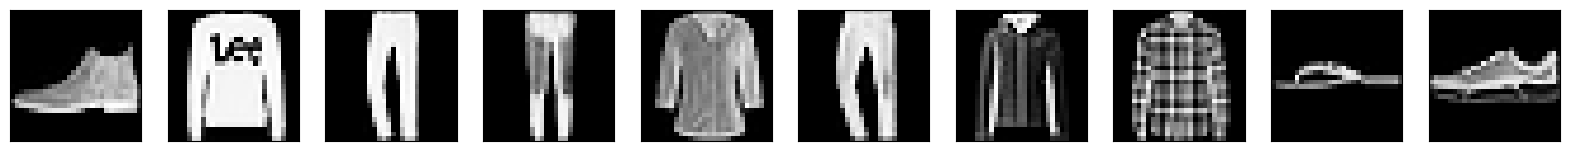

Generated:


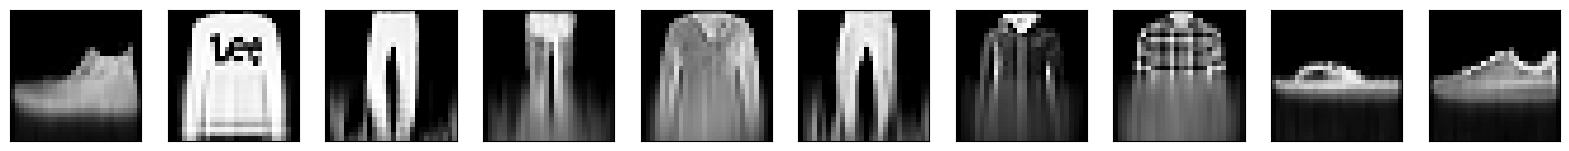

Epoch: 2 Loss_Train: 0.012462884741553614
Original:


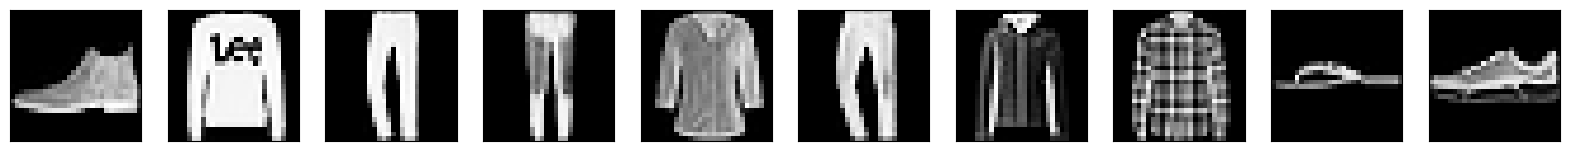

Generated:


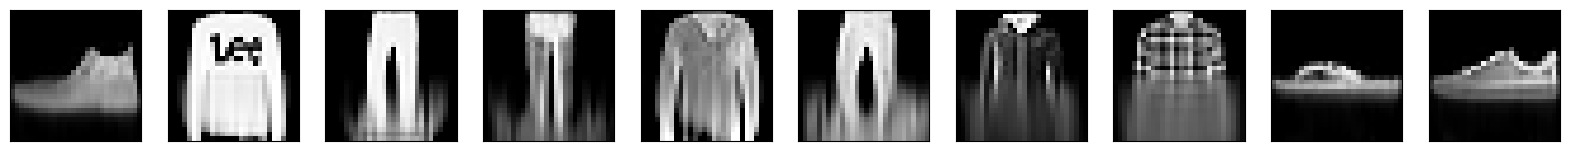

Epoch: 3 Loss_Train: 0.011854159610189013
Original:


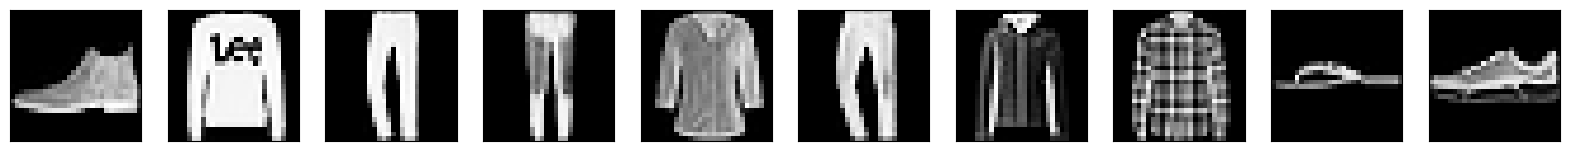

Generated:


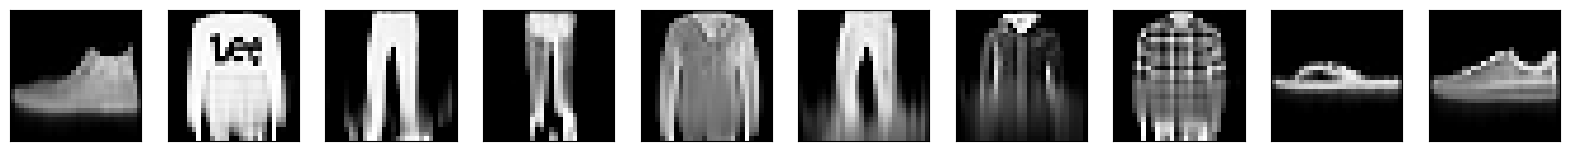

Epoch: 4 Loss_Train: 0.011463070160160292
Original:


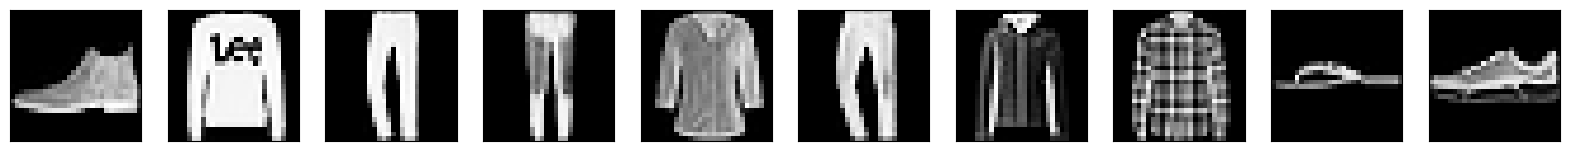

Generated:


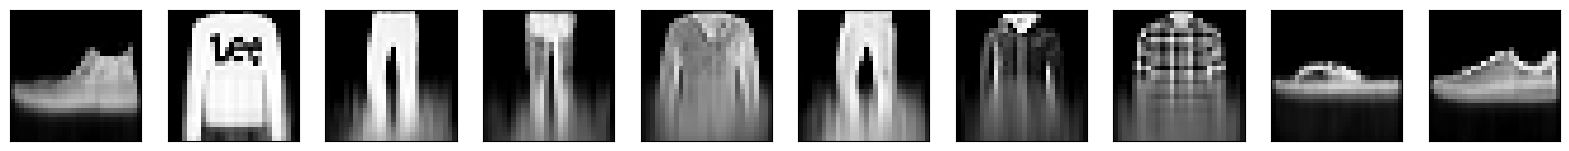

Epoch: 5 Loss_Train: 0.011159629257046494
Original:


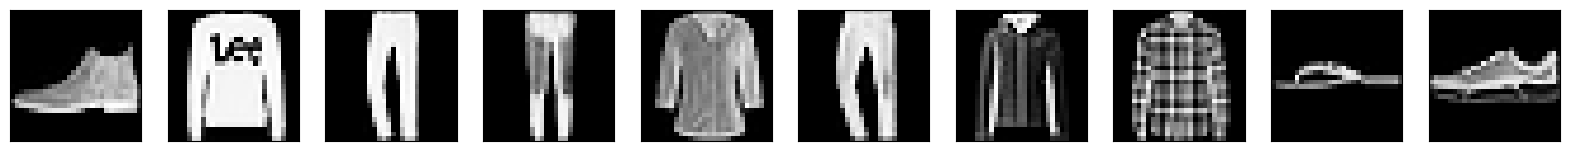

Generated:


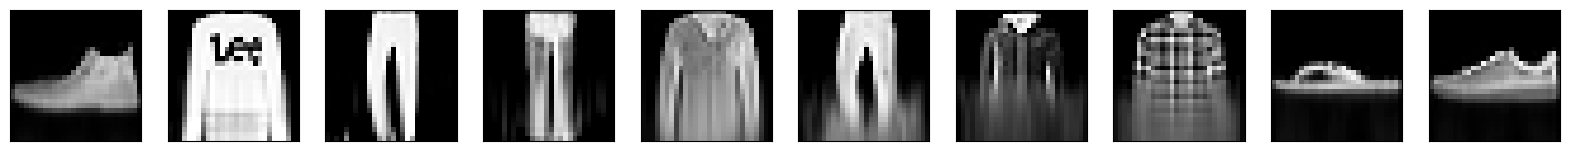

Epoch: 6 Loss_Train: 0.010911272591229402
Original:


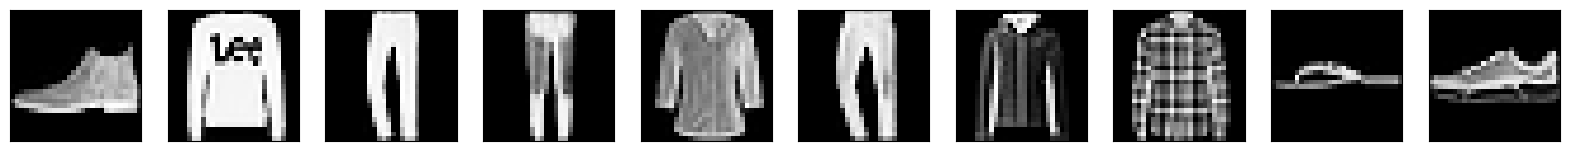

Generated:


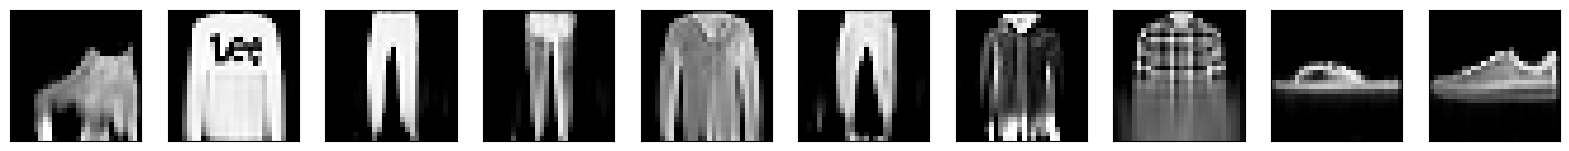

Epoch: 7 Loss_Train: 0.010703291276203897
Original:


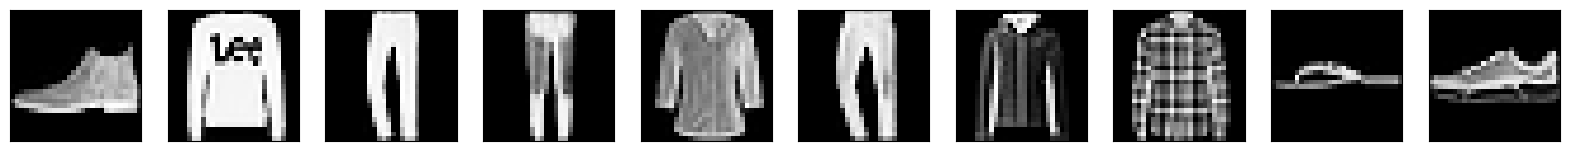

Generated:


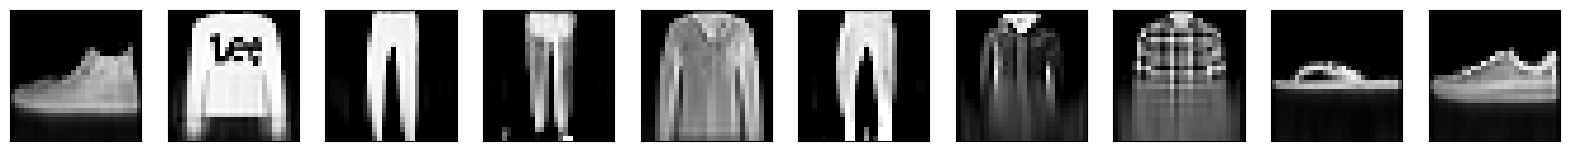

Epoch: 8 Loss_Train: 0.01052205869381668
Original:


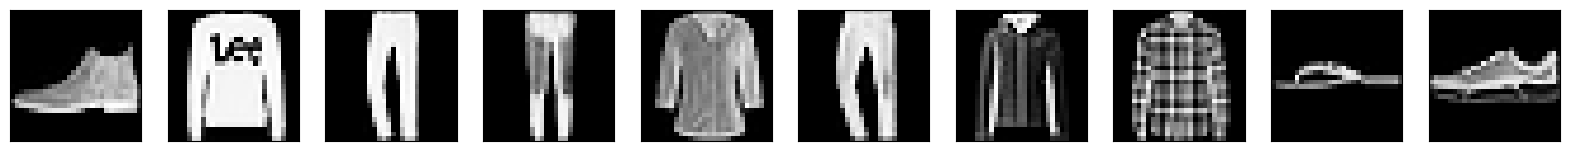

Generated:


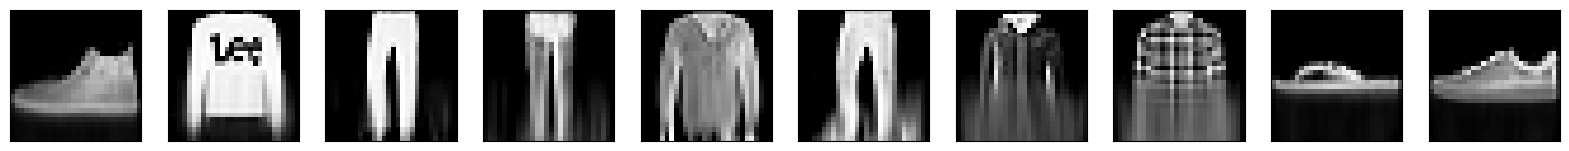

Epoch: 9 Loss_Train: 0.010355937189865149
Original:


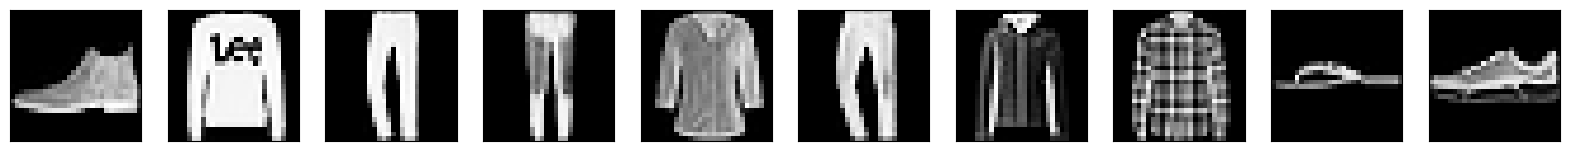

Generated:


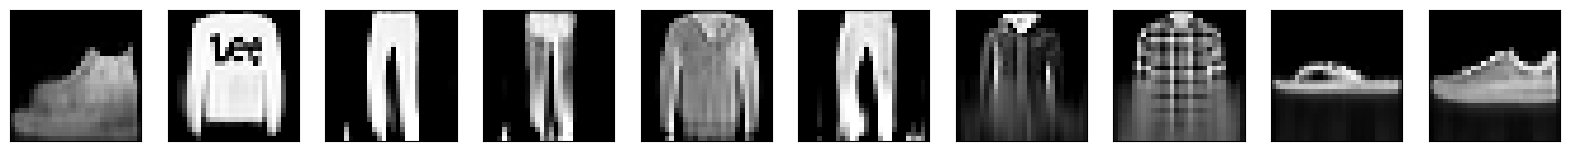

Epoch: 10 Loss_Train: 0.010205744178921698
Original:


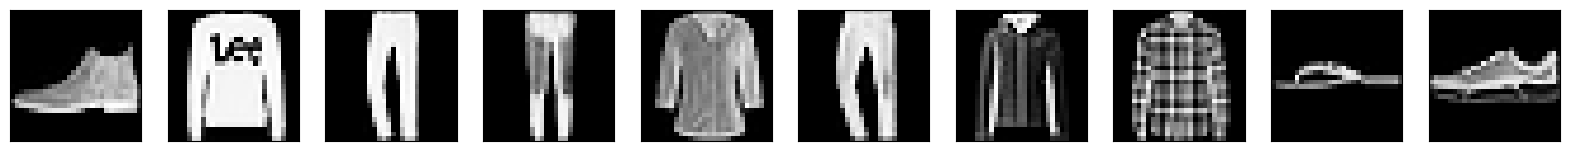

Generated:


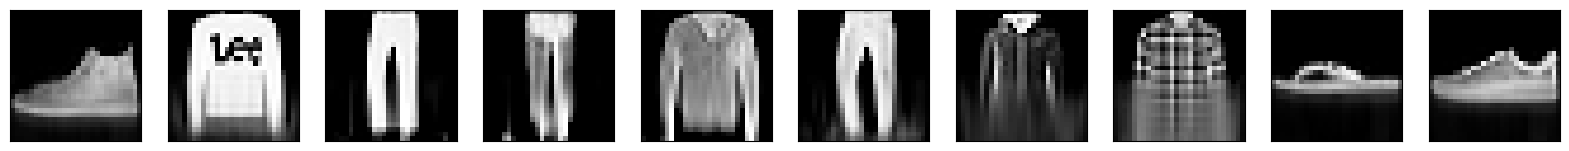

Epoch: 11 Loss_Train: 0.010076290980332211
Original:


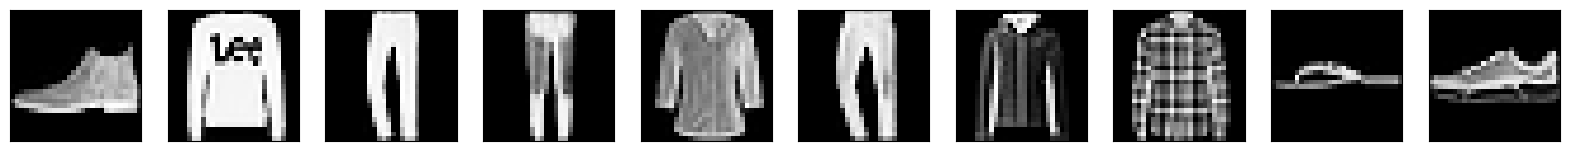

Generated:


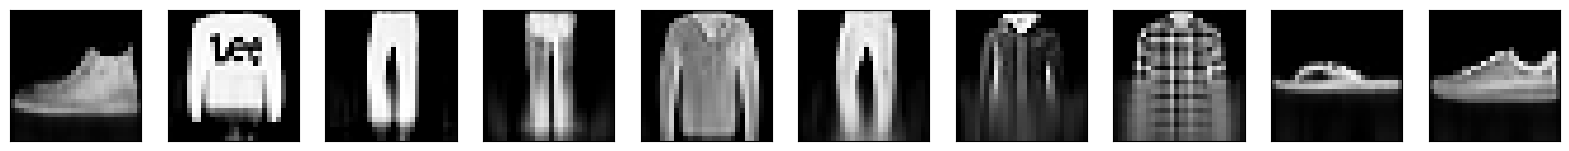

Epoch: 12 Loss_Train: 0.009947244829733652
Original:


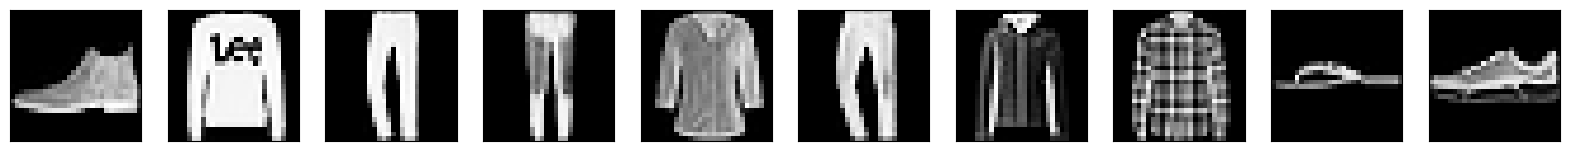

Generated:


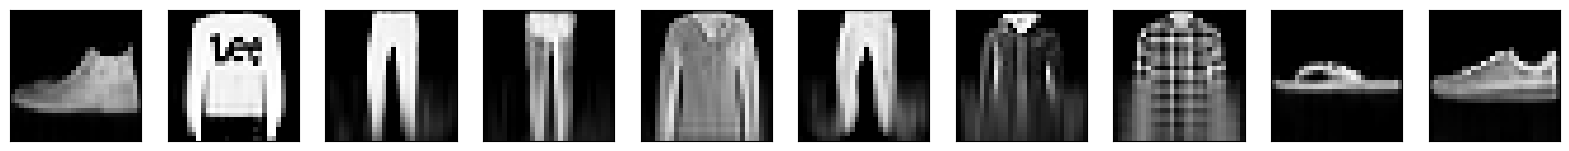

Epoch: 13 Loss_Train: 0.009830563883157369
Original:


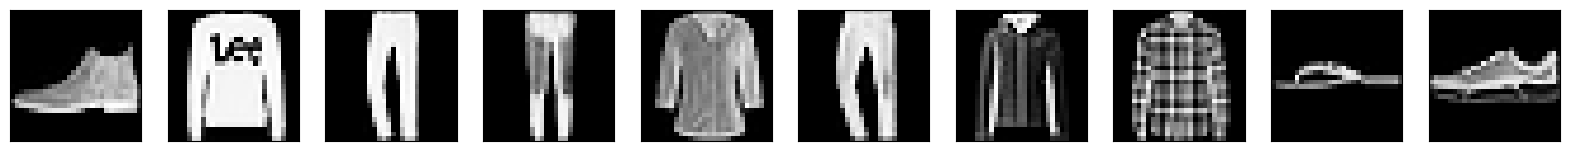

Generated:


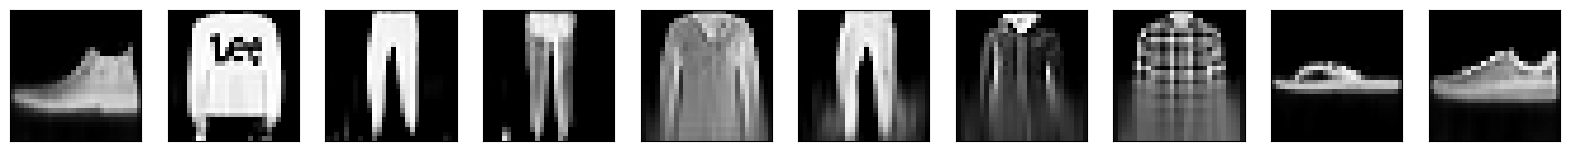

Epoch: 14 Loss_Train: 0.009719726745065903
Original:


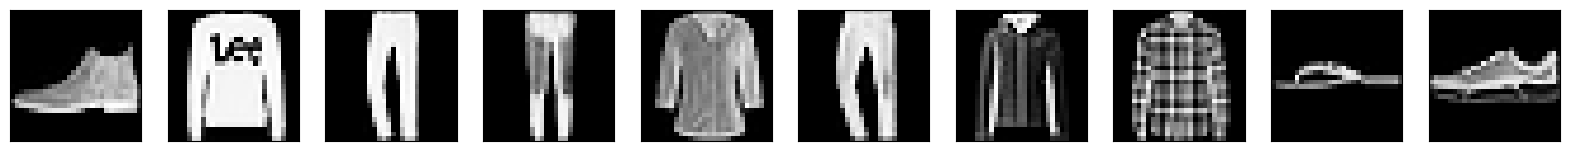

Generated:


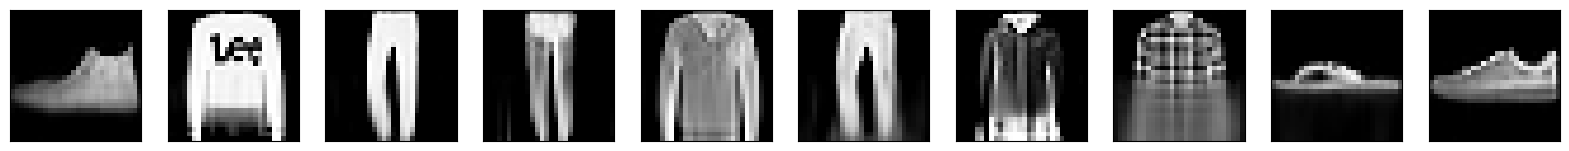

Epoch: 15 Loss_Train: 0.009612888307498665
Original:


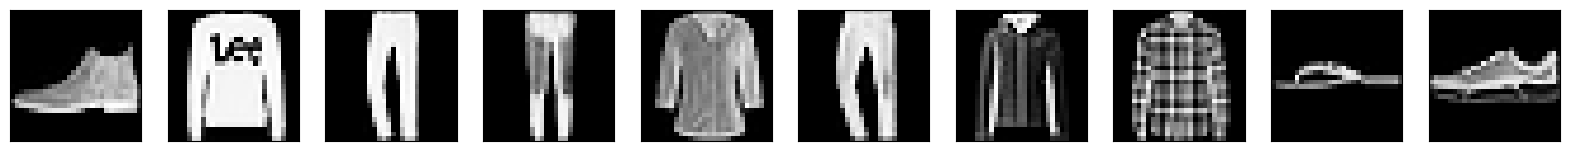

Generated:


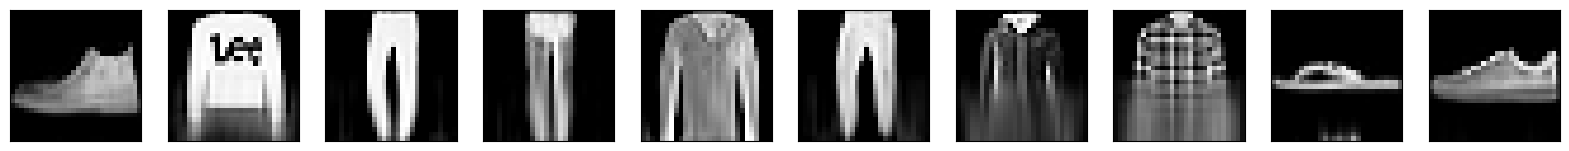

Epoch: 16 Loss_Train: 0.009518127947402618
Original:


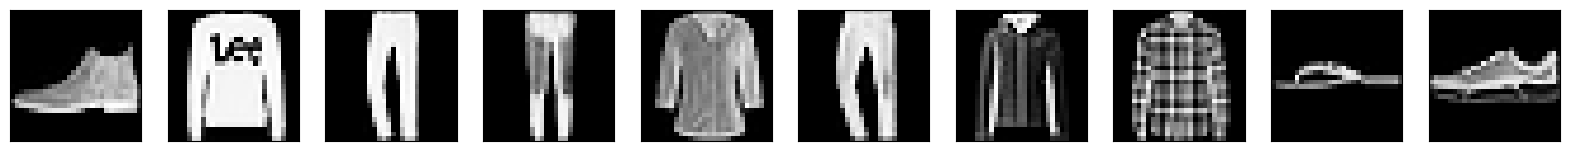

Generated:


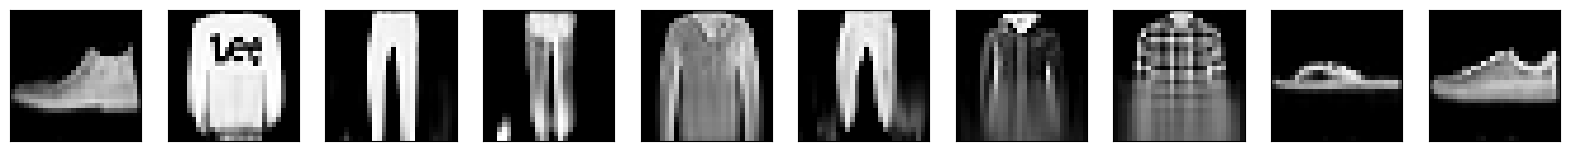

Epoch: 17 Loss_Train: 0.009435790659269168
Original:


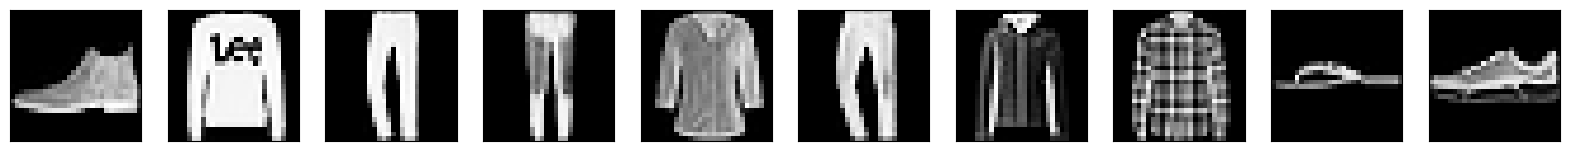

Generated:


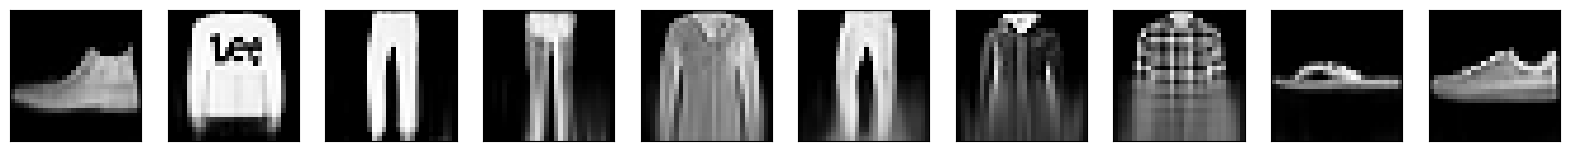

Epoch: 18 Loss_Train: 0.009353504475173783
Original:


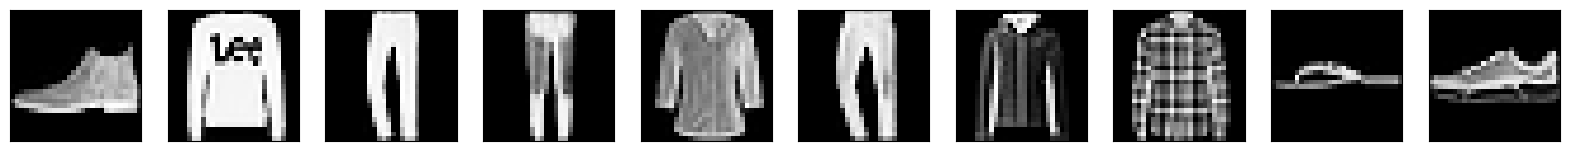

Generated:


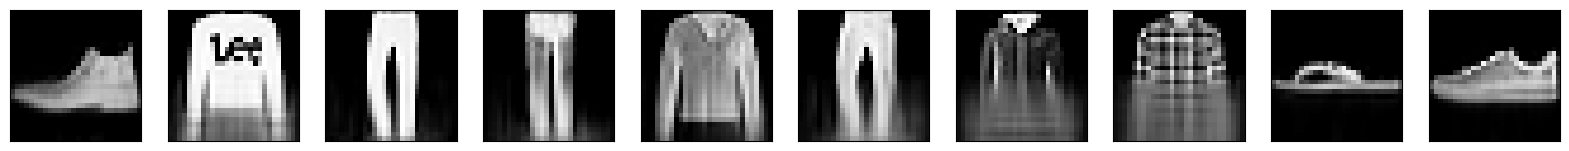

Epoch: 19 Loss_Train: 0.009272267105111476
Original:


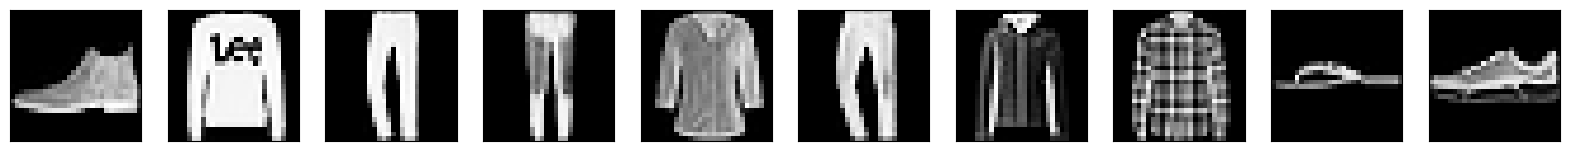

Generated:


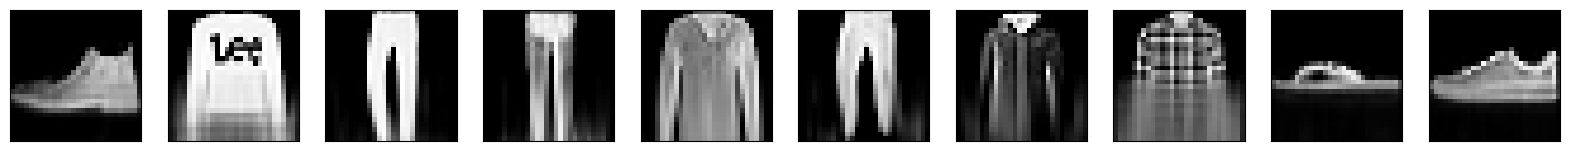

Epoch: 20 Loss_Train: 0.009202773537462385
Original:


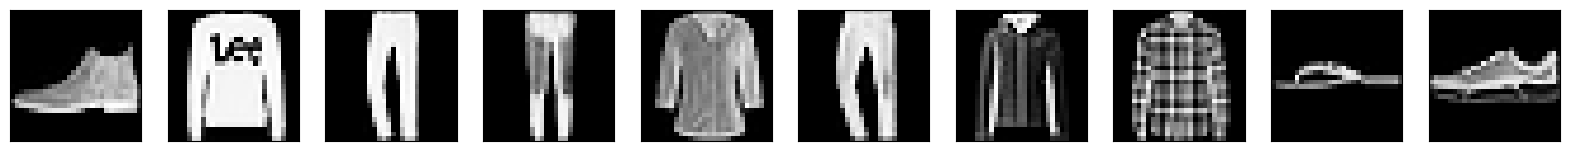

Generated:


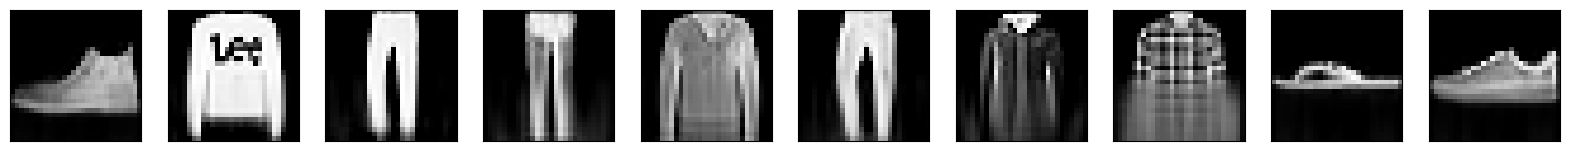

Epoch: 21 Loss_Train: 0.009131668100898974
Original:


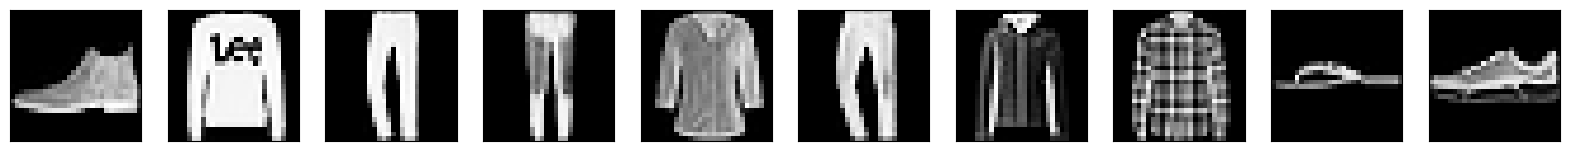

Generated:


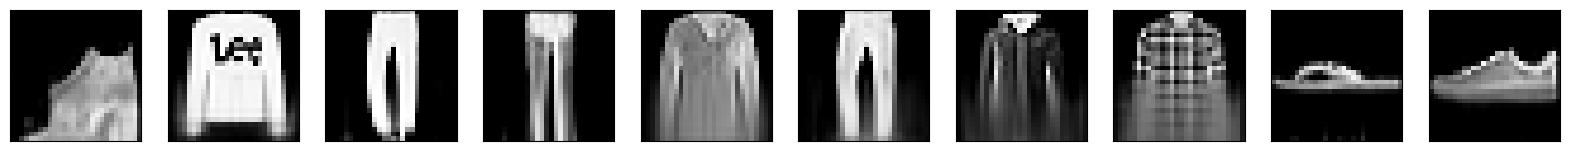

Epoch: 22 Loss_Train: 0.009072345644877022
Original:


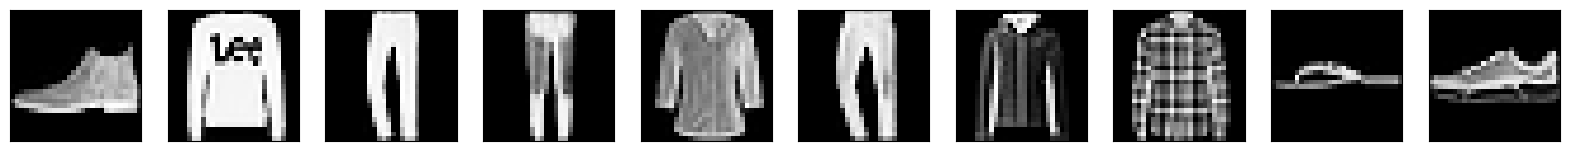

Generated:


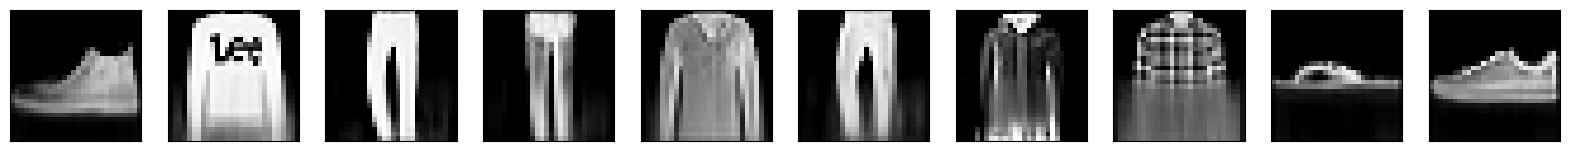

Epoch: 23 Loss_Train: 0.0090083508802237
Original:


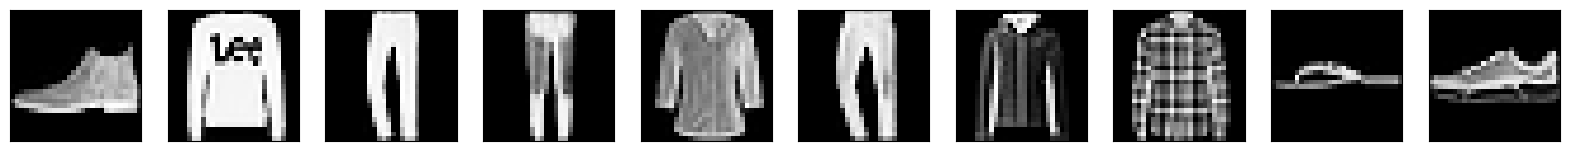

Generated:


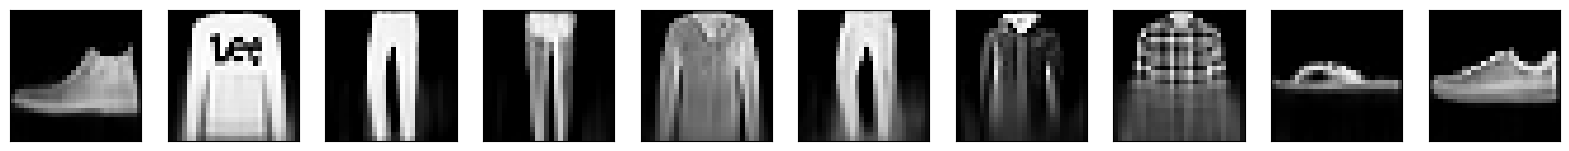

Epoch: 24 Loss_Train: 0.008958282336421253
Original:


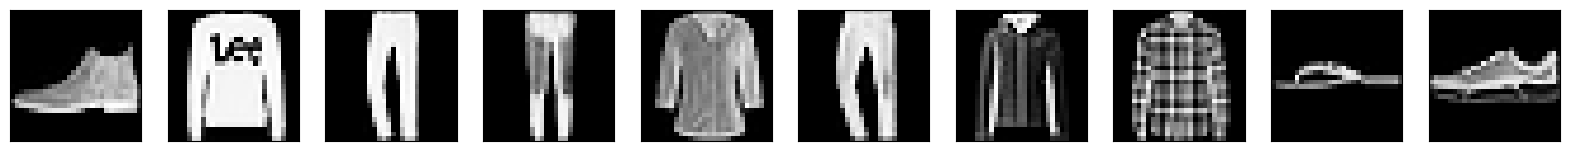

Generated:


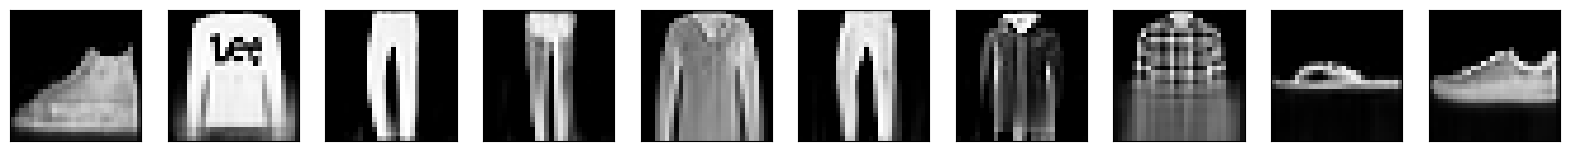

In [11]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.MSELoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())  # 学習率は0.01

# 損失のログ
record_loss_train = []

# 学習
for i in range(25):  # 25エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train)
        generate_images()

## 誤差の推移
誤差の推移をグラフ表示します。  

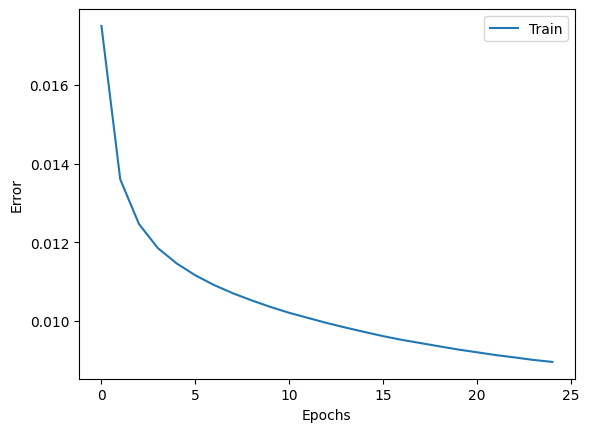

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

滑らかに誤差が減少していることが確認できます。